# 1. Importing required libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os

import nltk
from nltk.tokenize import word_tokenize
from nltk import PorterStemmer
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [2]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

## 2. Reading Data

In [3]:
data = pd.read_csv('/kaggle/input/chicago-crime-dataset-10000/ChicagoCrime_10000.csv')
data.head()

,Unnamed: 0,id,case_number,date,block,iucr,primary_type,description,location_description,arrest,...,location,:@computed_region_awaf_s7ux,:@computed_region_6mkv_f3dw,:@computed_region_vrxf_vc4k,:@computed_region_bdys_3d7i,:@computed_region_43wa_7qmu,:@computed_region_rpca_8um6,:@computed_region_d9mm_jgwp,:@computed_region_d3ds_rm58,:@computed_region_8hcu_yrd4
0,0,13470649,JH275914,2024-10-18T00:00:00.000,051XX S HOMAN AVE,1753,OFFENSE INVOLVING CHILDREN,SEXUAL ASSAULT OF CHILD BY FAMILY MEMBER,RESIDENCE,False,...,"{'latitude': '41.799867167', 'longitude': '-87...",49.0,22248.0,61.0,776.0,8.0,56.0,13.0,129.0,14.0
1,1,13624081,JH460344,2024-10-02T00:00:00.000,007XX E 131ST ST,1150,DECEPTIVE PRACTICE,CREDIT CARD FRAUD,APARTMENT,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,13619386,JH454578,2024-10-02T00:00:00.000,032XX S CANAL ST,0910,MOTOR VEHICLE THEFT,AUTOMOBILE,STREET,False,...,"{'latitude': '41.835788129', 'longitude': '-87...",26.0,21194.0,58.0,223.0,48.0,40.0,23.0,170.0,7.0
3,3,13617310,JH452186,2024-10-02T00:00:00.000,007XX E 93RD ST,0326,ROBBERY,AGGRAVATED VEHICULAR HIJACKING,STREET,False,...,"{'latitude': '41.72568353', 'longitude': '-87....",30.0,21546.0,40.0,430.0,43.0,61.0,20.0,248.0,10.0
4,4,13618144,JH453046,2024-10-02T00:00:00.000,094XX S ASHLAND AVE,5000,OTHER OFFENSE,OTHER CRIME AGAINST PERSON,BANK,False,...,"{'latitude': '41.722578383', 'longitude': '-87...",18.0,21554.0,72.0,195.0,13.0,59.0,9.0,245.0,21.0


## 3. Preprocessing Data

### 3.1 Dropping the NaN values

In [4]:
data.dropna(inplace = True)

### 3.2 Leaving out the columns we won't use

In [5]:
data = data[['primary_type', 'description', 'location_description']]
data

,primary_type,description,location_description
0,OFFENSE INVOLVING CHILDREN,SEXUAL ASSAULT OF CHILD BY FAMILY MEMBER,RESIDENCE
2,MOTOR VEHICLE THEFT,AUTOMOBILE,STREET
3,ROBBERY,AGGRAVATED VEHICULAR HIJACKING,STREET
4,OTHER OFFENSE,OTHER CRIME AGAINST PERSON,BANK
5,THEFT,THEFT FROM MOTOR VEHICLE,STREET
...,...,...,...
9995,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT
9996,ASSAULT,AGGRAVATED - HANDGUN,APARTMENT
9997,OTHER OFFENSE,VIOLATE ORDER OF PROTECTION,APARTMENT
9998,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT


### 3.3 Reading the frequency of crime types

In [6]:
data['primary_type'].value_counts()

primary_type
THEFT                                2266
BATTERY                              1874
CRIMINAL DAMAGE                      1131
ASSAULT                               937
MOTOR VEHICLE THEFT                   899
OTHER OFFENSE                         623
ROBBERY                               393
DECEPTIVE PRACTICE                    373
BURGLARY                              369
WEAPONS VIOLATION                     275
NARCOTICS                             198
CRIMINAL TRESPASS                     191
CRIMINAL SEXUAL ASSAULT                57
OFFENSE INVOLVING CHILDREN             52
SEX OFFENSE                            47
PUBLIC PEACE VIOLATION                 44
STALKING                               26
INTERFERENCE WITH PUBLIC OFFICER       25
HOMICIDE                               25
ARSON                                  22
PROSTITUTION                           21
LIQUOR LAW VIOLATION                    7
CONCEALED CARRY LICENSE VIOLATION       7
INTIMIDATION         

### 3.4 Keeping only the 5 most frequent crime types

In [7]:
crime_type = ['THEFT', 'BATTERY', 'CRIMINAL DAMAGE', 'MOTOR VEHICLE THEFT', 'ASSAULT']
#crime_type = ['CRIMINAL DAMAGE']
ind = 0

for index, row in data.iterrows():
    if row['primary_type'] not in crime_type:
        i = data[((data.primary_type == row['primary_type']) & (data.description == row['description']) & (data.location_description == row['location_description']))].index
        data.drop(i, inplace = True)
        
data['primary_type'].unique()

array(['MOTOR VEHICLE THEFT', 'THEFT', 'CRIMINAL DAMAGE', 'BATTERY',
       'ASSAULT'], dtype=object)

### 3.5 Preprocessing text data

#### 3.5.1 Combining primary_type, description, and local_description into one column

In [8]:
index = 0
for index, row in data.iterrows():
    new_description = [row['description'], row['location_description']]
    new_description = ' '.join(new_description)
    data.loc[index, 'description'] = new_description
    
data.drop('location_description', axis = 1, inplace = True)
data

,primary_type,description
2,MOTOR VEHICLE THEFT,AUTOMOBILE STREET
5,THEFT,THEFT FROM MOTOR VEHICLE STREET
8,CRIMINAL DAMAGE,TO PROPERTY APARTMENT
10,BATTERY,SIMPLE SCHOOL - PUBLIC GROUNDS
13,THEFT,FROM BUILDING APARTMENT
...,...,...
9994,MOTOR VEHICLE THEFT,"CYCLE, SCOOTER, BIKE WITH VIN STREET"
9995,BATTERY,DOMESTIC BATTERY SIMPLE APARTMENT
9996,ASSAULT,AGGRAVATED - HANDGUN APARTMENT
9998,BATTERY,DOMESTIC BATTERY SIMPLE APARTMENT


#### 3.5.2 Encoding the primary type using nominal encoding

In [9]:
data.primary_type = data.primary_type.astype('category').cat.codes
data

,primary_type,description
2,3,AUTOMOBILE STREET
5,4,THEFT FROM MOTOR VEHICLE STREET
8,2,TO PROPERTY APARTMENT
10,1,SIMPLE SCHOOL - PUBLIC GROUNDS
13,4,FROM BUILDING APARTMENT
...,...,...
9994,3,"CYCLE, SCOOTER, BIKE WITH VIN STREET"
9995,1,DOMESTIC BATTERY SIMPLE APARTMENT
9996,0,AGGRAVATED - HANDGUN APARTMENT
9998,1,DOMESTIC BATTERY SIMPLE APARTMENT


#### 3.5.3 Removing non-word, tokenizing, stemming, and lammatizing the description column

In [10]:
# Removing non words:
remove_non_alphabets =lambda x: re.sub(r'[^a-zA-Z]',' ',x)

# Tokenize:
tokenize = lambda x: word_tokenize(x)

# Stem:
ps = PorterStemmer()
stem = lambda w: [ ps.stem(x) for x in w ]

# Lemmatize:
lemmatizer = WordNetLemmatizer()
leammtizer = lambda x: [ lemmatizer.lemmatize(word) for word in x ]

In [11]:
print('Processing: [=', end='')

data['description'] = data['description'].apply(remove_non_alphabets)
print('=', end='')
data['description'] = data['description'].apply(tokenize) # [ word_tokenize(row) for row in data['email']]
print('=', end='')
data['description'] = data['description'].apply(stem)
print('=', end='')
data['description'] = data['description'].apply(leammtizer)
print('=', end='')
data['description'] = data['description'].apply(lambda x: ' '.join(x))
print('] Completed', end='')
    
data

Processing: [=====] Completed

,primary_type,description
2,3,automobil street
5,4,theft from motor vehicl street
8,2,TO properti apart
10,1,simpl school public ground
13,4,from build apart
...,...,...
9994,3,cycl scooter bike with vin street
9995,1,domest batteri simpl apart
9996,0,aggrav handgun apart
9998,1,domest batteri simpl apart


#### 3.5.4 Vectorizing description column

In [12]:
# Vectorizing:
max_words = 10000
cv = CountVectorizer(max_features=max_words, stop_words='english')
sparse_matrix = cv.fit_transform(data['description']).toarray()

In [13]:
sparse_matrix.shape

(7107, 175)

# 4. Training

### 4.1 Creating train and test splits

In [263]:
x_train, x_test, y_train, y_test = train_test_split(sparse_matrix, np.array
                                                    (data['primary_type']))

### 4.2 Defining the model

In [264]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(175, 100)
        self.linear2 = nn.Linear(100, 10)
        self.linear3 = nn.Linear(10, 5)
        
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [265]:
model = NeuralNetwork()

### 4.3 Defining the loss function and optimizer

In [266]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters() , lr=0.01)

### 4.4 Converting the training data into tensors

In [267]:
x_train = Variable(torch.from_numpy(x_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()

### 4.5 Training the model using the training set

In [268]:
epochs = 50
model.train()
loss_values = []
for epoch in range(epochs):
    optimizer.zero_grad()
    y_pred = model(x_train)
    loss = criterion(y_pred, y_train)
    loss_values.append(loss.item())
    pred = torch.max(y_pred, 1)[1].eq(y_train).sum()
    acc = pred * 100.0 / len(x_train)
    print('Epoch: {}, Loss: {}, Accuracy: {}%'.format(epoch+1, loss.item(), acc.numpy()))
    loss.backward()
    optimizer.step()


Epoch: 1, Loss: 1.5890610218048096, Accuracy: 20.619136810302734%
Epoch: 2, Loss: 1.5742378234863281, Accuracy: 26.378986358642578%
Epoch: 3, Loss: 1.5600425004959106, Accuracy: 35.00938034057617%
Epoch: 4, Loss: 1.5409128665924072, Accuracy: 53.07692337036133%
Epoch: 5, Loss: 1.5161144733428955, Accuracy: 56.191368103027344%
Epoch: 6, Loss: 1.484574794769287, Accuracy: 54.3151969909668%
Epoch: 7, Loss: 1.4451662302017212, Accuracy: 54.18386459350586%
Epoch: 8, Loss: 1.3978877067565918, Accuracy: 54.22138977050781%
Epoch: 9, Loss: 1.3435195684432983, Accuracy: 54.22138977050781%
Epoch: 10, Loss: 1.2839218378067017, Accuracy: 54.3151969909668%
Epoch: 11, Loss: 1.2210993766784668, Accuracy: 54.78424072265625%
Epoch: 12, Loss: 1.1564297676086426, Accuracy: 57.93621063232422%
Epoch: 13, Loss: 1.0909520387649536, Accuracy: 58.21763610839844%
Epoch: 14, Loss: 1.0246690511703491, Accuracy: 67.91744995117188%
Epoch: 15, Loss: 0.9556306004524231, Accuracy: 68.6303939819336%
Epoch: 16, Loss: 0.8

### 4.6 Plotting the loss

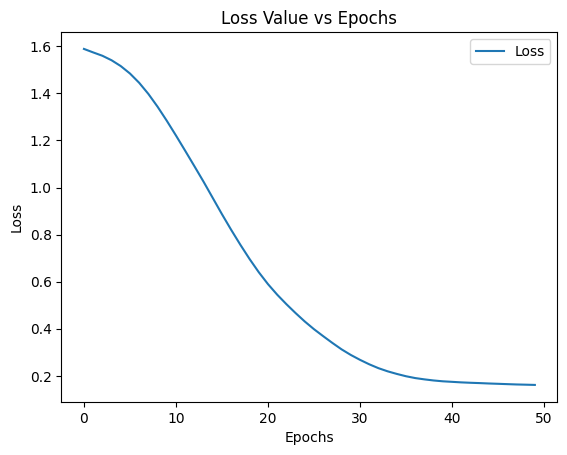

In [269]:
plt.plot(loss_values)
plt.title('Loss Value vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Loss'])
plt.show()

# 5. Testing

### 5.1 Converting testing data to tensors

In [270]:
x_test = Variable(torch.from_numpy(x_test)).float()
y_test = Variable(torch.from_numpy(y_test)).long()

### 5.2 Evaluating the model using test set

In [271]:
model.eval()
with torch.no_grad():
    y_pred = model(x_test)
    loss = criterion(y_pred, y_test)
    pred = torch.max(y_pred, 1)[1].eq(y_test).sum()
    print ("Accuracy : {}%".format(100*pred/len(x_test)))


Accuracy : 90.32076263427734%
